In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Brownian definition 

In [25]:
T=1 # temps final
N=255
N=255*8*4
dt=T/N
timerange = np.linspace(0,T,N+1,endpoint=True)
timerange=timerange[:,None]
print(timerange.shape)

M=150 #no de realisations
#construction de Wt:
Wt=np.zeros((N+1,M))
W0=0
dW=np.sqrt(dt)*np.random.randn(N,M)
Wt[0,:]=W0
Wt[1:,:]=W0+np.cumsum(dW,0)

S0=100.0
mu=0.1
sigma=0.15
taux_r=0.05

(8161, 1)


### Underlying asset

In [16]:
def sousjacent(mu,sigma,t,Wt):
#  St = S0 * exp( (mu-sigma*sigma/2.0)*t + sigma*Wt) 
  return S0*np.exp( (mu-sigma**2.0/2.0)*t+ sigma*Wt)

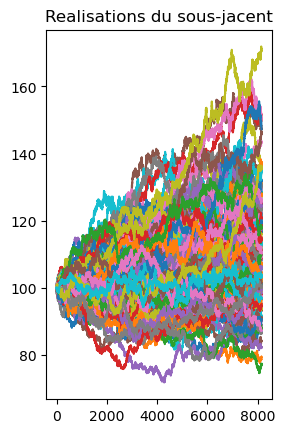

In [17]:
St= sousjacent(mu,sigma,timerange,Wt)
St_risque_neutre=sousjacent(taux_r,sigma,timerange,Wt)
plt.subplot(1,2,2)
plt.plot(St)
plt.title('Realisations du sous-jacent')
plt.savefig("realisations_Wt_St.jpg")

In [19]:
def blsprice(Price,Strike,Rate,TimeToMaturity,Volatility,DividendRate=0):
    """input:
       S:Price - Current price of the underlying asset.
    
       Strike:Strike - Strike (i.e., exercise) price of the option.
    
       Rate: Rate - Annualized continuously compounded risk-free rate of return over
         the life of the option, expressed as a positive decimal number.
    
       TimeToMaturity:Time - Time to expiration of the option, expressed in years.
    
      Volatility: volatility
      DividendRate = continuous dividend rate
    """   
    if TimeToMaturity <= 1e-6: # the option already expired
        call = np.max(Price-Strike,0)
        put = np.max(Strike-Price,0)
        return call,put
            
    d1 = np.log(Price/Strike)+(Rate-DividendRate + Volatility**2/2.0)*TimeToMaturity;
    d1 = d1/(Volatility* np.sqrt(TimeToMaturity))
    d2 = d1-(Volatility*np.sqrt(TimeToMaturity))
    
    call = Price * np.exp(-DividendRate*TimeToMaturity) * norm.cdf(d1)-Strike* np.exp(-Rate*TimeToMaturity) * norm.cdf(d2)
    put  = Strike* np.exp(-Rate*TimeToMaturity) * norm.cdf(-d2)-Price* np.exp(-DividendRate*TimeToMaturity) * norm.cdf(-d1)
    return call,put

In [18]:
def blsdelta(Price,Strike,Rate,TimeToMaturity,Volatility,DividendRate=0):
    """input:
       S:Price - Current price of the underlying asset.
    
       Strike:Strike - Strike (i.e., exercise) price of the option.
    
       Rate: Rate - Annualized continuously compounded risk-free rate of return over
         the life of the option, expressed as a positive decimal number.
    
       TimeToMaturity:Time - Time to expiration of the option, expressed in years.
    
      Volatility: volatility
      DividendRate = continuous dividend rate
    """
    if TimeToMaturity <= 1e-6: # the option already expired
        call = (Price>=Strike).astype(np.float64) # 1 if in the money, zero otherwise
        put = -(Price<=Strike).astype(np.float64) # cf above
        return call,put
    d1 = np.log(Price/Strike)+(Rate-DividendRate + Volatility**2/2.0)*TimeToMaturity;
    d1 = d1/(Volatility* np.sqrt(TimeToMaturity))
    
    call =  np.exp(-DividendRate*TimeToMaturity) * norm.cdf(d1)
    put  = -np.exp(-DividendRate*TimeToMaturity) * norm.cdf(-d1)
    return call,put

### Monte Carlo

Prix monte Carlo :4.113183953577662
Prix BS :4.075865972892551


Text(0.5, 1.0, 'hist du payoff Monte Carlo')

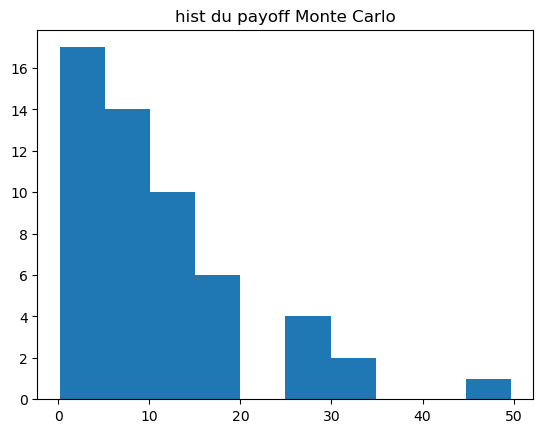

In [24]:
# calcul Monte Carlo
# calcul de la valeur finale de l'option : call de strike K, CT = (ST-K)+
K=110 # strike
CT = np.maximum(St_risque_neutre[-1,:]-K,0) # utilisation de St a l'instant final
#prix = valeur finale, actualisation
distrib_prix_option = np.exp(-taux_r*T) * CT
prix_option=np.mean(distrib_prix_option)
print(f"Prix monte Carlo :{prix_option}")
prix_call,_=blsprice(S0,K,taux_r,T,sigma)
print(f"Prix BS :{prix_call}")
plt.figure()
plt.hist(distrib_prix_option[distrib_prix_option>0])
plt.title('hist du payoff Monte Carlo')

### Delta hedging
On simule la situation d'un vendeur de call qui se couvre de maniere dynamique en achetant Delta_t parts de sous-jacent : 

- delta = + d C_t / d S

 t=0 : 
- vente option cash = cash + prix option (celui de blsprice)
- mise en place du portefeuille de replication

Text(0.5, 1.0, 'hist du cash')

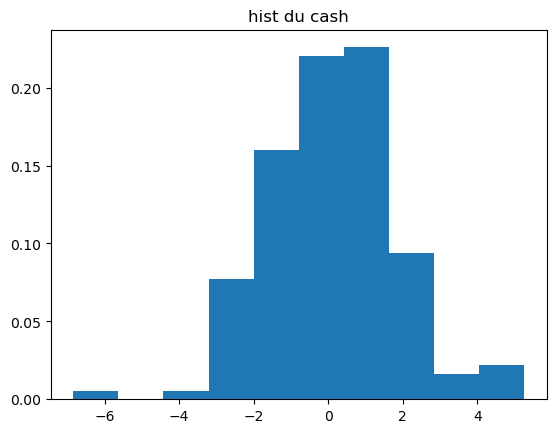

In [23]:
cash = np.zeros_like(St)
prix_call,_=blsprice(S0,K,taux_r,T,sigma)
deltaancien,_=blsdelta(S0,K,taux_r,T,sigma) #calcul de delta
cash[0,:]=prix_call - deltaancien*S0

for jj in range(N):
  cash[jj+1,:]= cash[jj,:]*np.exp(taux_r*dt)# capitalisation
  #calcul du nouveau delta
  deltanouveau,_ = blsdelta(St[jj+1,:],K,taux_r,T-timerange[jj+1,0],sigma)
  cash[jj+1,:]= cash[jj+1,:]- (deltanouveau-deltaancien)*St[jj+1,:] #prix de la prise en compte du delta hedging
  # t -> t + dt : ajustement de porfef. de replication, capitalisation cash
  deltaancien=deltanouveau

cash[-1,:] -=np.maximum(St[-1,:]-K,0)#perte due a la livraison 
cash[-1,:] += deltanouveau*St[-1,:]#cash obtenu par la vente du portef de couverture 

# histogramme du cash
plt.figure('test')
plt.hist(cash[-1,:]*100/prix_call,density=True)
plt.title('hist du cash' )